**Install and import cobra + import neccessary libraries**

In [ ]:
!pip install cobra
import cobra
import matplotlib.pyplot as plt
from cobra import flux_analysis as fva
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
!pip install markupsafe==2.0.1
!pip install escher
import escher

**Load the SBML file (XML format)**

In [9]:
model = cobra.io.load_model("iJO1366")

**Flux Variability Analysis**

We can often reach some maximal objective value using different solutions. For example, the biomass objective can be maximized by multiple flux distributions (flux A could be 0.3 and flux B could be 0.6, or flux A could be 0 and flux B could 0.9, and so on for all the fluxes). We want to do an exercise to see which reactions can be changed (and to what degree) to maintain the same maximum biomass flux.

In [10]:
# 1. We want to see the optimal biomass flux in normal conditions. We should ensure the boundaries are correct.

# Realistic glucose uptake
model.reactions.EX_glc__D_e.lower_bound = -18.5
# Practically unlimited oxygen intake
model.reactions.EX_o2_e.lower_bound = -1000
# Making the biomass reaction as the objective
model.objective = 'BIOMASS_Ec_iJO1366_core_53p95M'
solution = model.optimize()
solution

# So the optimal biomass flux is 1.828.


,fluxes,reduced_costs
DM_4crsol_c,0.000408,0.000000
DM_5drib_c,0.000411,0.000000
DM_aacald_c,0.000000,0.000000
DM_amob_c,0.000004,0.000000
DM_mththf_c,0.000819,0.000000
...,...,...
ZN2abcpp,0.000000,-0.008295
ZN2t3pp,0.000000,-0.002074
ZN2tpp,0.000624,0.000000
ZNabcpp,0.000000,-0.008295


In [11]:
# 2. We want to use the optimal biomass flux as a constraint to the model! That is, both the upper and lower bound should be 1.828.
model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.lower_bound = 1.828
model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.upper_bound = 1.828

In [12]:
# 3. Set the reaction of interest as the objective, and use FBA to minimize and maximize this new objective in two separate steps!
model.objective = 'EX_succ_e'
model.objective.direction = 'max'
solution = model.optimize()

model.objective.direction = 'min'
solution2 = model.optimize()

print(solution)
print(solution2)

<Solution 0.009 at 0x78be90db34c0>
<Solution 0.000 at 0x78be8981feb0>


Here we can see that upon maximal biomass flux (growth), the cell can either not use succinate at all, or it can still use it up to 0.009 mmol/gDw.hr!

Do all fluxes vary? What are the pathways/substrates that the cell MUST use for it to achieve the optimal biomass? We can answer these questions by finding the min and max. values for ALL the reactions' fluxes!

In [13]:
# Perform flux variability analysis with the fixed biomass flux
fva_solution = fva.variability.flux_variability_analysis(model, fraction_of_optimum=1.0)
fva_solution

,minimum,maximum
DM_4crsol_c,0.000408,0.000408
DM_5drib_c,0.000411,0.002171
DM_aacald_c,0.000000,0.000000
DM_amob_c,0.000004,0.000004
DM_mththf_c,0.000819,0.005989
...,...,...
ZN2abcpp,0.000000,0.118910
ZN2t3pp,0.000000,0.475639
ZN2tpp,0.000000,0.476263
ZNabcpp,0.000000,0.095253


Now that you have a dataframe with all the min and max flux values, we want to do some exploratory data analysis. For this part, you are required to draw conclusions based on some simple data analysis.

1) **Which reactions are crucial for optimal growh? and which reactions are not important for optimal growth?.** Explain with words and then show these specific reactions with code.

2)  **What percentage of the reactions has a min. of 0 (and a max not 0)? And what percentage has a max. of 0 (and a min not 0)? And what percentage has both min and max of 0 (meaning the reaction is completely shut off)? And what percentage has both min and max not 0?**

In [ ]:
# Your answers here.
# 1.
# 2.

**Robustness Analysis**

In this method, the flux through one reaction is varied and the optimal objective value is calculated as a function of this flux.  This reveals how **sensitive** the objective is to a particular reaction.

We want to see the effect of nutrient uptake on growth. First, we set oxygen uptake to 17 mmol/gDw.hr, which is a realistic uptake. Then, we change glucose uptake rate from 0 to 20, and see its effect on growth. We will also make a plot to see this relation better.

In [14]:
# Before we do anything, we neet to reset our biomass boundaries since we changed them in the previous exercise.
# The default biomass lower boundary is 0, and the maximum is 1000.
model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.lower_bound = 0
model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.upper_bound = 1000

model.reactions.EX_o2_e.lower_bound = -17
model.objective = 'BIOMASS_Ec_iJO1366_core_53p95M'
model.objective.direction = 'max'
dict_growth = {}
for i in range(0,21):
  model.reactions.EX_glc__D_e.lower_bound = -i
  solution = model.optimize()
  dict_growth[i] = solution.objective_value

/usr/local/lib/python3.10/dist-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


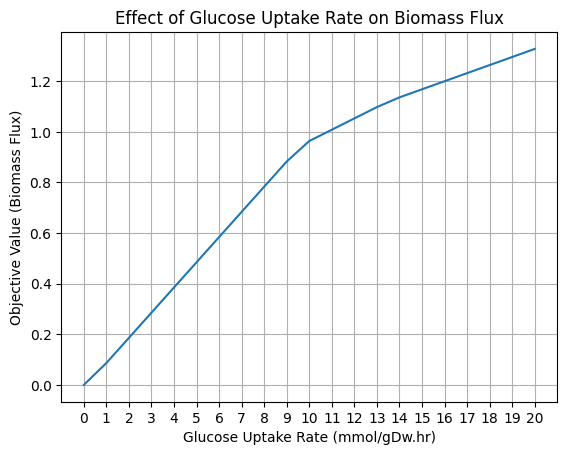

In [15]:
glucose_uptake_rates = list(dict_growth.keys())
objective_values = list(dict_growth.values())

plt.plot(glucose_uptake_rates, objective_values)
plt.xlabel('Glucose Uptake Rate (mmol/gDw.hr)')
plt.ylabel('Objective Value (Biomass Flux)')
plt.title('Effect of Glucose Uptake Rate on Biomass Flux')
plt.grid(True)
plt.xticks(range(0, 21, 1))
plt.show()

As we can see from the plot, it's a positive relationship. The more glucose, the more biomass. We can also see that the derivative decreases after glucose uptake = -10, meaning that the biomass is more sensitive to the change of glucose when it's very low than when it becomes excess.

We want to know what's the least amount of glucose needed to obtain a little bit of growth. By simple trial and error, we find that 0.14 is the minimal uptake rate of glucose needed for just 0.0001 of growth. That is because any uptake rate less than 0.14 is not even enough to make the NGAM (the lower bound constraint of the ATPM reaction).

In [16]:
model.reactions.EX_glc__D_e.lower_bound = -0.14
solution = model.optimize()
solution

,fluxes,reduced_costs
DM_4crsol_c,1.332598e-07,0.000000
DM_5drib_c,1.344550e-07,0.000000
DM_aacald_c,1.320837e-15,0.000000
DM_amob_c,1.195155e-09,0.000000
DM_mththf_c,2.677148e-07,0.000000
...,...,...
ZN2abcpp,0.000000e+00,-0.008537
ZN2t3pp,0.000000e+00,-0.002134
ZN2tpp,2.037740e-07,0.000000
ZNabcpp,0.000000e+00,-0.008537


Why did the derivative decrease at a glucose uptake rate of 10? Because at this point, oxygen and not glucose is the limiting factor. Excess glucose cannot be fully oxidized, so the fermentation pathways are used.

The oxygen uptake rate can also be varied with the glucose uptake rate held constant.  With glucose uptake fixed at 10 mmol gDW-1 hr-1, growth rate increases steadily as oxygen uptake increases.

In [17]:
model.reactions.EX_glc__D_e.lower_bound = -10

model.objective = 'BIOMASS_Ec_iJO1366_core_53p95M'
model.objective.direction = 'max'
dict_growth = {}
for i in range(0,26):
  model.reactions.EX_o2_e.lower_bound = -i
  solution = model.optimize()
  dict_growth[i] = solution.objective_value

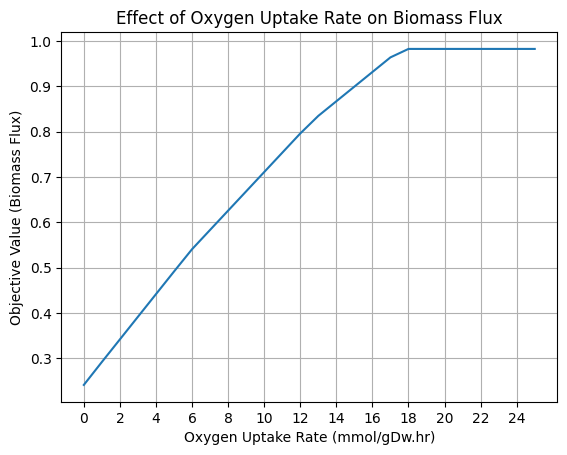

In [18]:
oxygen_uptake_rates = list(dict_growth.keys())
objective_values = list(dict_growth.values())

plt.plot(oxygen_uptake_rates, objective_values)
plt.xlabel('Oxygen Uptake Rate (mmol/gDw.hr)')
plt.ylabel('Objective Value (Biomass Flux)')
plt.title('Effect of Oxygen Uptake Rate on Biomass Flux')
plt.grid(True)
plt.xticks(range(0, 26, 2))
plt.show()

**At a fixed glucose rate of 10mmol/gDw.hr, we can see that oxygen uptake rates > 18 do not affect the growth at all! The question is why?**

**Your answer here.**

Now we want to see the effect of BOTH glucose and oxygen on growth. We want to vary the uptake of glucose from 0 to 20 and so on for oxygen to see the effect of all 400 combinations on growth! We use a nested for loop to do that.

In [19]:
model.objective = 'BIOMASS_Ec_iJO1366_core_53p95M'
model.objective.direction = 'max'
dict_growth = {}
for i in range(0,21):
  for j in range(0, 21):
    model.reactions.EX_glc__D_e.lower_bound = -i
    model.reactions.EX_o2_e.lower_bound = -j
    solution = model.optimize()
    dict_growth[(i, j)] = solution.objective_value

And now we plot what's called a "**phenotypic phase plane**". Notice the two "phases" or areas shaded in different colors.

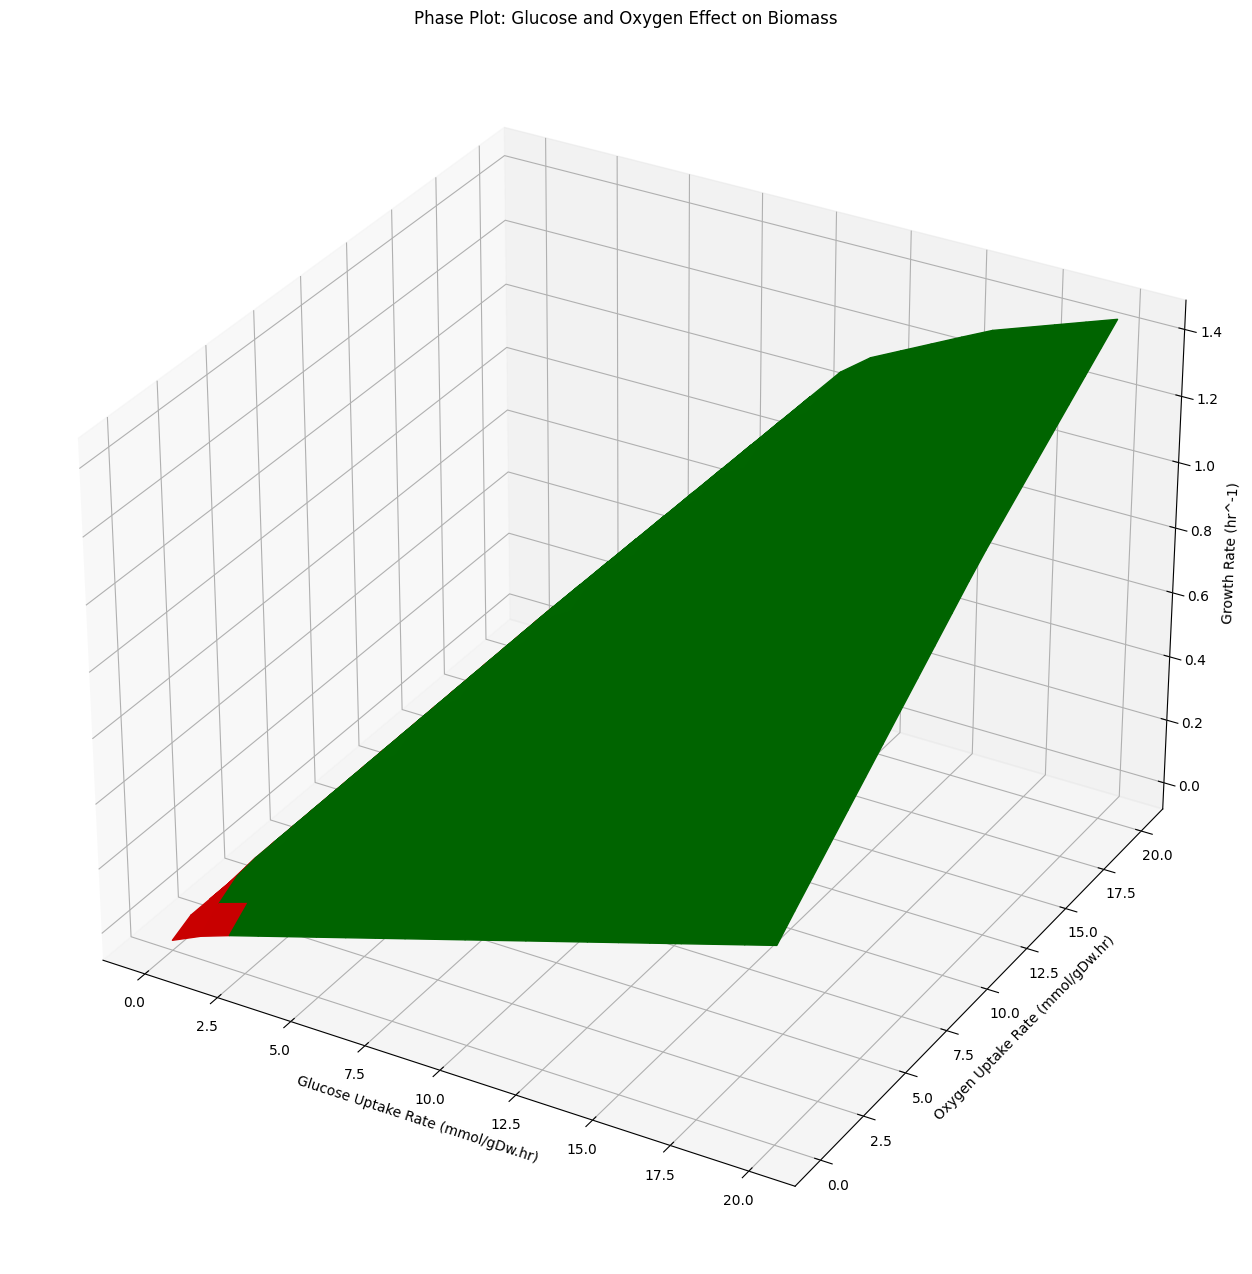

In [20]:
glucose_rates = [k[0] for k in dict_growth.keys()]
oxygen_rates = [k[1] for k in dict_growth.keys()]
biomass_flux = list(dict_growth.values())

oxygen_rates = np.array(oxygen_rates)
glucose_rates = np.array(glucose_rates)
biomass_flux = np.array(biomass_flux)

glucose_grid, oxygen_grid = np.meshgrid(np.unique(glucose_rates), np.unique(oxygen_rates))

Z = griddata((glucose_rates, oxygen_rates), biomass_flux, (glucose_grid, oxygen_grid), method='linear')


fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')

positive_biomass_mask = Z > 0

zero_biomass_mask = Z == 0

colors = np.where(Z > 0, 'green', 'red')  # Green for positive biomass, Red for zero biomass

ax.plot_surface(glucose_grid, oxygen_grid, Z, facecolors=colors)

ax.set_xlabel('Glucose Uptake Rate (mmol/gDw.hr)')
ax.set_ylabel('Oxygen Uptake Rate (mmol/gDw.hr)')
ax.set_zlabel('Growth Rate (hr^-1)')
ax.set_title('Phase Plot: Glucose and Oxygen Effect on Biomass')

plt.show()

**Gene Deletion Simulation (Virtual CRISPR Screening)**

To simulate the knockout of any gene, its associated reaction(s) can simply be constrained to not carry flux.  By setting both the upper and lower bounds of a reaction to 0 mmol gDW-1 hr-1, a reaction is essentially knocked out, and is restricted from carrying flux.  

The model contains a list of gene protein-reaction interactions (GPRs), a list of Boolean rules that dictate which genes are connected with each reaction in the model. When a reaction is catalyzed by isozymes (two different enzymes that
catalyze the same reaction), the associated GPR contains an “or” rule, where either of two or more
genes may be knocked out but the reaction will not be constrained.

For example, the GPR for phosphofructokinase (PFK) is “b1723 (pfkB) or b3916 (pfkA),” so according to this Boolean rule, **both pfkB and pfkA** must be knocked out to restrict this reaction.  

When a reaction is catalyzed by a protein with multiple essential subunits, the GPR contains an “and” rule, and if any of the genes are knocked out the reaction will be constrained to 0 flux.  Succinyl-CoA synthetase (SUCOAS), for example, has the GPR “b0728 (sucC) and b0729 (sucD),” so knocking out **either of these genes** will restrict this reaction.

We now want to know which genes are **essential** for growth, meaning if they are knocked out the biomass flux becomes 0!

In [21]:
# first, let's see how to fetch the GPRs.
print(model.reactions.PFK.gene_reaction_rule)
print(model.reactions.SUCOAS.gene_reaction_rule)

b3916 or b1723
b0728 and b0729


In [22]:
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)

# model.reactions.PFK.delete() # this is how you delete a "reaction"
# model.genes.b1723.knock_out() # and this is how you knock out a "gene"

In [23]:
model = cobra.io.load_model("iJO1366")
# to see the effect of all single-gene deletions on the objective
gene_deletion_results = single_gene_deletion(model)

In [34]:
gene_deletion_results

,ids,growth,status
0,{b0698},0.982372,optimal
1,{b3469},0.982372,optimal
2,{b2262},0.982372,optimal
3,{b0895},0.982372,optimal
4,{b0692},0.982372,optimal
...,...,...,...
1362,{b2261},0.982372,optimal
1363,{b4374},0.982372,optimal
1364,{b0070},0.982372,optimal
1365,{b2251},0.982372,optimal


In [25]:
model = cobra.io.load_model("iJO1366")
# to see the effect of all single reaction deletions on the objective
rxn_deletion_results = single_reaction_deletion(model)

In [33]:
rxn_deletion_results

,ids,growth,status
0,{EX_xmp_e},0.982372,optimal
1,{ECOAH7},0.980958,optimal
2,{PLIPA1A161pp},0.982372,optimal
3,{ACOAD3f},0.972037,optimal
4,{R5Ptex},0.982372,optimal
...,...,...,...
2578,{EX_ppal_e},0.982372,optimal
2579,{GLUABUTt7pp},0.982372,optimal
2580,{GLDBRAN2},0.982372,optimal
2581,{LIPOtex},0.982372,optimal


1. How many **genes** are essential and how many are non-essential?
2. How many **reactions** are essential and how many are non-essential?
3. What does that may indicate about bacteria and their GPRs?

In [ ]:
# Your answer here.

In [35]:
model = cobra.io.load_model("iJO1366")

In [36]:
def print_gene_info(gene):
    print("cobra_id: ",gene.id)
    print("name: ",gene.name)
    print("associated reactions:")
    for reac in gene.reactions:
        print(reac.id, ', ', reac.name)
    return

growth_rate = cobra.flux_analysis.single_gene_deletion(model, {model.genes.b1136} )
print("Growth when knocking out b1136: ", growth_rate['growth'][0])

# Let's use our gene function from above to see which reactions does this gene participate in.
print_gene_info(model.genes.b1136)

# Now that we know it participates in ICDHyr reaction, let's see the reaction..
print('\n', model.reactions.ICDHyr)

Growth when knocking out b1136:  0.0
cobra_id:  b1136
name:  
associated reactions:
ICDHyr ,  Isocitrate dehydrogenase (NADP)

 ICDHyr: icit_c + nadp_c <=> akg_c + co2_c + nadph_c


The gene icd encodes for the enzyme that catalyzes the oxidative decarboxylation of isocitrate, producing a-ketoglutarate (a-KG) and CO2. The reaction is part of the TCA cycle.

We want to see the Escher map before and after when an essential gene such as icd is knocked out.

In [37]:
model = cobra.io.load_model("iJO1366")
model_modified = model.copy()
model_modified.reactions.ICDHyr.delete()
metabolicMap = escher.Builder(map_name='iJO1366.Central metabolism',
                              model=model_modified,
                              # in the map, highlight all reactions that are missing from the model
                              highlight_missing=True,
                              # only show the primary metabolites
                              hide_secondary_metabolites=True)
metabolicMap.save_html('map_with_rxn_deleted.html')

/usr/local/lib/python3.10/dist-packages/cobra/core/group.py:147: UserWarning: need to pass in a list
  warn("need to pass in a list")


Although the TCA cycle allows maximal energy yield from degradation of glucose, its more critical role is to supply precursors for biosynthetic pathways that branch from a-ketoglutarate, oxaloacetate, and succinyl CoA. **As evident in the map, there is only one way to make a-KG, so the segment of the cycle leading to a-KG is essential.**

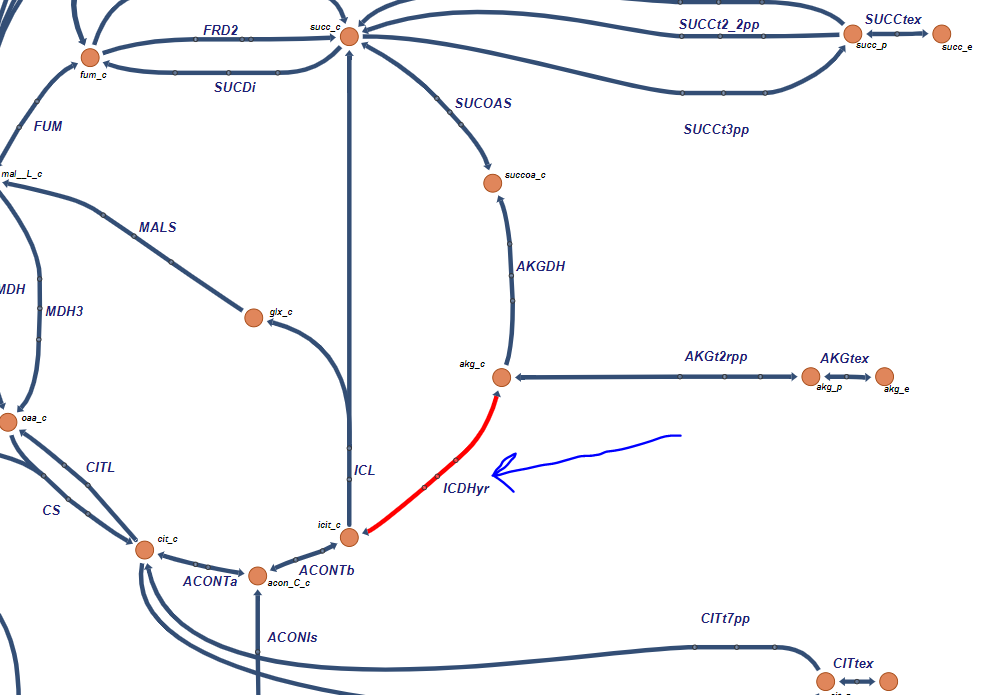

References:
1. https://github.com/webermarcolivier/metabolic_modelling_jupyter_tutorial/blob/master/Solution/tutorial5_FBA_exercise1_solution.ipynb
2. https://www.nature.com/articles/nbt.1614
3. https://www.embopress.org/doi/full/10.1038/msb.2011.65
4. http://bigg.ucsd.edu/models/iJO1366